In [162]:
# Load the required packages

import pandas as pd
import numpy as np 
import re

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

from urllib.parse import urlparse,urlencode
from bs4 import BeautifulSoup
from datetime import datetime
import ipaddress
import whois
import urllib
import urllib.request
import tldextract

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Phishing Dataset

In [296]:
phishing_raw_df = pd.read_csv("/Users/swarupagowri/Desktop/MS Data Analytics/DATA245/Project/Datasets/Main_dataset.csv", header = 0)

In [297]:
phishing_raw_df = phishing_raw_df.dropna()
phishing_raw_df = phishing_raw_df.drop_duplicates()
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
phishing_raw_df.shape

(72363, 12)

In [298]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


Class Legitimate URL: 31025
Class Phishing URL: 41338
Proportion: 0.75 : 1


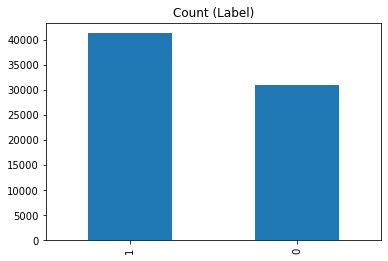

In [299]:
target_count = phishing_raw_df.label.value_counts()
print('Class Legitimate URL:', target_count[0])
print('Class Phishing URL:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (Label)');

Random under-sampling:
1    31025
0    31025
Name: label, dtype: int64


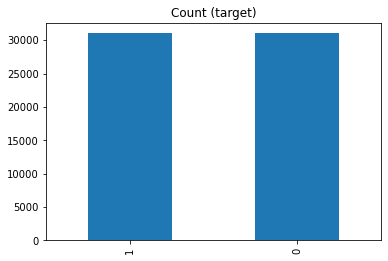

In [300]:
# Class count
count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Divide by class
df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

df_class_1_under = df_class_1.sample(count_class_0)
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='Count (target)');

In [301]:
phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
12639,www.paypal.com.nl.cgi.bin.webscr.cmd.login.pro...,10000000,0,0,0,116,0,0,1,115,15,1
47426,songxia-battery.com/js/?mod=www&amp;ssl=0,10000000,0,1,3288,41,0,0,1,19,1,1
49818,netinterbank.org/user/,10000000,0,0,0,22,0,0,0,16,1,1
54035,www.aol.com.update.gatestohell.co.in/AolServic...,10000000,0,0,0,68,0,0,0,36,6,1
43185,bsacodo.fr/wp-content/upgrade/f.htm,10000000,0,0,0,35,0,0,0,10,1,1


## Data Pre-processing

In [302]:
# Across the entire dataset, 0 indicates legitimate url and 1 indicates phishing url
# Legitimate - 0; Phishing - 1

# Function to check rank of the URL
# Returns 0 if the rank is less than 100000 for the given URL else returns 1

def rank(url):
    try:
    #Filling the whitespaces in the URL if any
        url = urllib.parse.quote(url)
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&url=" + url).read(), "xml").find(
            "REACH")['RANK']
        rank = int(rank)
    except TypeError:
        return 1
    if rank <100000:
        return 0
    else:
        return 1

# Function to check if an IP is found in the URL
# Returns 1 if IP is found in the given URL else returns 0

def isIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

# Function to validity of the URL domain
# Returns 1 if age of the domain is less than 6 else returns 0

def isValid(domain_name):
    creation_date = domain_name.creation_date
    expiration_date = domain_name.expiration_date
    if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
        try:
            creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
            expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
              return 1
    if ((expiration_date is None) or (creation_date is None)):
        return 1
    elif ((type(expiration_date) is list) or (type(creation_date) is list)):
        return 1
    else:
        ageofdomain = abs((expiration_date - creation_date).days)
        if ((ageofdomain/30) < 6):
            age = 1
        else:
            age = 0
    return age

# Function to check the expiration of the URL domain
# Returns 1 if the domain has expired else returns 0

def domain_reg_len(domain_name):
    expiration_date = domain_name.expiration_date
    if isinstance(expiration_date,str):
        try:
            expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
            return 1
    if (expiration_date is None):
        return 1
    elif (type(expiration_date) is list):
        return 1
    else:
        today = datetime.now()
        end = abs((expiration_date - today).days)
        if ((end/30) < 6):
            end = 0
        else:
            end = 1
    return end

In [303]:
# Function to check for '@' in the URL
# Returns 1 if found else returns 0

def isat(url):
    if "@" in url:
        return 1    
    else:
        return 0    

# Function to check for '//' in the URL
# Returns 1 if found within length of 7 for the given URL or if 'http' is found else returns 0

def isRedirect(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# Function to check for '-' in the URL
# Returns 1 if found else returns 0

def haveDash(url):
    if '-' in urlparse(url).netloc:
        return 1            
    else:
        return 0    
    
# Function to check number of subdomains in the URL
# Returns 0 if number of subdomains is 1 else returns 1

def no_sub_domain(url):
    url = url.replace("www.","")
    url = url.replace("."+tldextract.extract(url).suffix,"")
    count = url.count(".")
    if count==1:
        return 0
    else:
        return 1

# Function to check for 'https' in the URL
# Returns 1 if found else returns 0

def httpDomain(url):
    domain = urlparse(url).netloc
    if 'http' in domain:
        return 1
    else:
        return 0

# Function to checks the length of the URL
# Returns 0 if the length is less than 54 else returns 1

def LongURL(url):
    if len(url) < 54:
        return 0            
    else:
        return 1            

#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

# Function to check if the URL belong to shortening services
# Returns 1 if found else returns 0

def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

In [304]:
# Feature engineering

# Insert a new column to the dataframe which shows if 'http' is found in the domain part of the URL.
phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: httpDomain(x))

# Insert a new column to the dataframe indicating the length of the URL.
phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: LongURL(x))

# Insert a new column to the dataframe indicating if the URL belongs to any of the shortening services.
phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: tinyURL(x))

# Alter the values in 'nosOfSubdomain' column of the dataframe.
# If the number of sub domains is more than 1, then it is a phishing site.
phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: no_sub_domain(x))

# Alter the values in 'activeDuration' column of the dataframe.
# If the value is greater than 365 (1 year), then it is a legitimate site.
phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Alter the values in the dataframe column 'ranking'
# If the value is greater than 100000, then it is a phishing site
phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Remove the unwanted columns from the dataframe
phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Reorder and rename the columns in the dataframe
Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)

# Shuffle the rows in the dataset so that when splitting the train and test set are equally distributed

phishing_raw_df = phishing_raw_df.sample(frac=1).reset_index(drop=True)

#Display the dataset after feature engineering

phishing_raw_df.head()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
0,1,0,1,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,1,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,0,1


In [305]:
phishing_raw_df.isnull().sum()

Rank              0
isIP              0
isValid           0
Domain_reg_len    0
is@               0
isRedirect        0
haveDash          0
SubDomain         0
Domain_http       0
LongURL           0
TinyURL           0
Label             0
dtype: int64

In [306]:
phishing_raw_df.describe()

,Rank,isIP,isValid,Domain_reg_len,is@,isRedirect,haveDash,SubDomain,Domain_http,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.0,62050.000000,62050.000000,62050.000000
mean,0.662305,0.000226,0.594230,0.411072,0.002385,0.006624,0.142595,0.549218,0.0,0.354988,0.069782,0.500000
std,0.472928,0.015019,0.491044,0.492032,0.048780,0.081117,0.349662,0.497576,0.0,0.478514,0.254782,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.500000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


<AxesSubplot:>

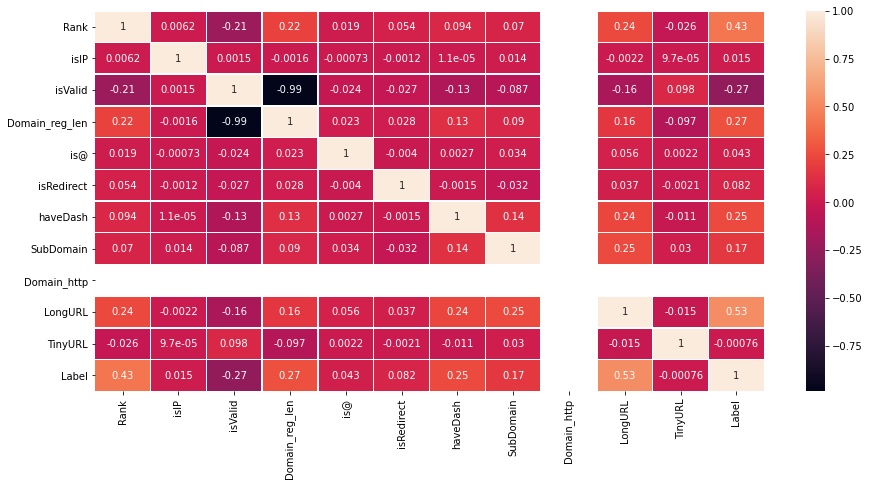

In [307]:
plt.figure(figsize=(15,7))
sns.heatmap(phishing_raw_df.corr(),annot=True, linewidth=0.5)

In [330]:
X=phishing_raw_df.drop(["Label"],axis=1)
Y=phishing_raw_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)
data_classes = ['0','1']

In [331]:
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
            max_depth = 5)
dtc = dtc.fit(X_train,y_train)

In [332]:
y_pred_test = dtc.predict(X_test)
y_pred_train = dtc.predict(X_train)

In [333]:
acc_train_dtc = accuracy_score(y_train,y_pred_train)
acc_test_dtc = accuracy_score(y_test,y_pred_test)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_dtc))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_dtc))

Decision Tree: Accuracy on training Data: 0.823
Decision Tree: Accuracy on test Data: 0.821


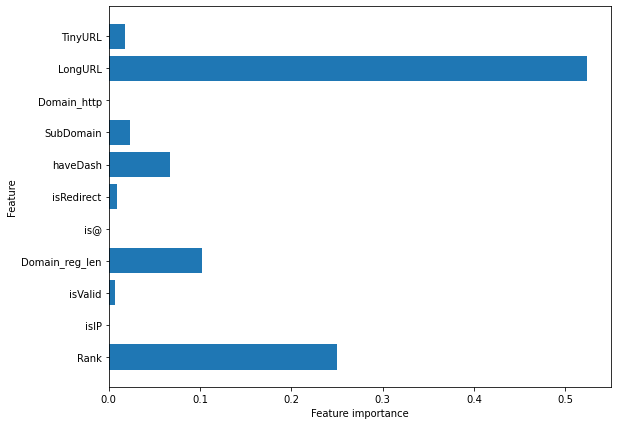

In [334]:
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), dtc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [335]:
feature_importance=(dict(zip(X.columns, dtc.feature_importances_)))
sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

[('LongURL', 0.5235760133096984),
 ('Rank', 0.2500868712025977),
 ('Domain_reg_len', 0.10180473057549184),
 ('haveDash', 0.06690907004905236),
 ('SubDomain', 0.023035242606692905),
 ('TinyURL', 0.018281657258829867),
 ('isRedirect', 0.008768933832194287),
 ('isValid', 0.0067579957914724875),
 ('is@', 0.0007794853739701784),
 ('isIP', 0.0),
 ('Domain_http', 0.0)]

In [341]:
X = phishing_raw_df.drop(["Domain_http","is@","isIP","Label"],axis=1)
Y = phishing_raw_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=101)

In [340]:
# Lists to store the model performance results
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
    ML_Model.append(model)
    acc_train.append(round(a, 3))
    acc_test.append(round(b, 3))


### XGBoost

In [342]:
%%time
XGB_model = XGBClassifier(random_state=0)
XGB_model.fit(X_train, y_train)

CPU times: user 7.73 s, sys: 528 ms, total: 8.26 s
Wall time: 1.16 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [343]:
%%time
y_XGB_test=XGB_model.predict(X_test)
y_XGB_train=XGB_model.predict(X_train)
storeResults('XGBoost',accuracy_score(y_train,y_XGB_train),accuracy_score(y_test,y_XGB_test))

CPU times: user 277 ms, sys: 56.1 ms, total: 333 ms
Wall time: 56.4 ms


              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6150
           1       0.84      0.79      0.82      6260

    accuracy                           0.82     12410
   macro avg       0.82      0.82      0.82     12410
weighted avg       0.82      0.82      0.82     12410



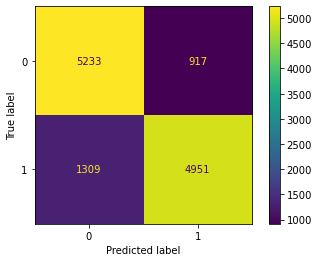

In [344]:
print(classification_report(y_test, y_XGB_test, target_names=['0','1']))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_XGB_test),display_labels=['0','1'])
disp.plot()

## Decision Tree

In [345]:
%%time
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
            max_depth = 5)
dtc = dtc.fit(X_train,y_train)

CPU times: user 25.1 ms, sys: 10.1 ms, total: 35.3 ms
Wall time: 41 ms


In [346]:
%%time
y_dtc_test = dtc.predict(X_test)
y_dtc_train = dtc.predict(X_train)
storeResults('Decision Tree',accuracy_score(y_train,y_dtc_train),accuracy_score(y_test,y_dtc_test))

CPU times: user 21.1 ms, sys: 3.7 ms, total: 24.8 ms
Wall time: 23.5 ms


              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6150
           1       0.84      0.79      0.82      6260

    accuracy                           0.82     12410
   macro avg       0.82      0.82      0.82     12410
weighted avg       0.82      0.82      0.82     12410



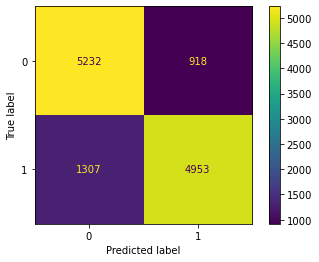

In [337]:
print(classification_report(y_test, y_dtc_test, target_names=['0','1']))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_dtc_test),display_labels=['0','1'])
disp.plot()

## Master function to invoke pre-processing functions

In [317]:
def featureExtraction(url):

    features = []
    #Domain based features (3)
    
    dns = 0
    try:
        domain_name = whois.whois(urlparse(url).netloc)
    except:
        dns = 1

    features.append(rank(url))
    features.append(1 if dns == 1 else isValid(domain_name))
    features.append(1 if dns == 1 else domain_reg_len(domain_name))
    
    
    #Address bar based features (5)
    
    features.append(isRedirect(url))
    features.append(haveDash(url))
    features.append(no_sub_domain(url))
    features.append(LongURL(url))
    features.append(tinyURL(url))
    #features.append(isIP(url))
    #features.append(isat(url)) 
    #features.append(httpDomain(url))
    
  
    return features

## Testing master function

In [322]:
#feature_names = ['Rank','isValid','Domain_reg_len','isRedirect','haveDash','SubDomain','LongURL','TinyURL']
#data = featureExtraction('http://kaizenpak.com/2/https/34.237.113.1134059/sucursalpersonas.transaccionesbancolombia.com/mua/index.html')
#test = pd.DataFrame(np.array(data).reshape((1,-1)))
#test.columns=feature_names
#XGB_model.predict(test)
#data_1 = featureExtraction('https://www.amazon.in/s?k=cloth&ref=nb_sb_noss')
#data_2 = featureExtraction('www.zvon.org/xxl/WSDL1.1/Output/index.html')
#test_1 = pd.DataFrame(np.array(data_2).reshape((1,-1)))
#test_1.columns=feature_names
#XGB_model.predict(test_1)